# Level 1 vs Level 2 Landsat Satellite Data:

## A comparison using Modified Normalised Difference Water Index (MNDWI)

* **Products used:** 
[ls8_usgs_sr_scene](https://explorer.digitalearth.africa/ls8_usgs_sr_scene)
* **Level 1 data retrived from:**
[Landsat 8 Level 1 data](https://registry.opendata.aws/landsat-8/) (last accessed 10 July 2020)

## Background

### Analysis-Ready Data (ARD): the difference between Level 1 and Level 2 data

Satellite operators, such as the USGS, perform pre-processing on raw satellite data before releasing it for use. The amount of pre-processing differs between products. The USGS taxonomy for the these differing amounts of pre-processing is ordered by `Levels`, and `Collections`.

The data we examine in this notebook is from the `USGS Collection 1` archive.

* **Collection 1, Level 1 data** : Level 1 data is very close to its raw format, it can be flexibly manipulated by the scientific community, but requires specialist knowledge to use. Atmospheric interference and other underlying satellite data issues are not corrected for.

* **Collection 1, Level 2 data**: The accessibility of available satellite data can be significantly increased by further processing the Level 1 data, such as by applying atmospheric corrections. Level 2 data is hosted on DE Africa's `OpenDataCube`, and is known as `Analysis-Ready Data (ARD)`. The corrections improve the overall quality of the data (compared to the Level 1 data) and allow users to conduct analysis independent of expertise in the data corrections process.

### Modified Normalised Difference Water Index (MNDWI)

MNDWI is a variation on the Normalised Difference Water Index (NDWI). NDWI is used to detect the presence of water bodies in remote sensing, and is calculated using the Green band and Near-Infrared (NIR) bands from satellite data.

\begin{equation} \text{NDWI} \ = \ \frac{\text{Green} - \text{NIR}}{\text{Green} + \text{NIR}} \end{equation}

However, it has been shown that using a Short-Range Infrared (SWIR) band instead of NIR provides enhanced delineation between water and other types of areas (soil, vegetation, built-up land). This gives the Modified NDWI, or MNDWI.

\begin{equation} \text{MNDWI} \ = \ \frac{\text{Green} - \text{SWIR}}{\text{Green} + \text{SWIR}} \end{equation}

In the case of Landsat 8 satellite data, which has two SWIR bands, SWIR 1 is used. The indices are normalised, which means their values range from -1 to 1. Generally, this can be interpreted as:

* MNDWI $> 0$ : water
* MNDWI $\leq 0$ : soil, vegetation, urban areas

## Description

This notebook will show how ARD (Level 2) data differs from the less pre-processed Level 1 data. This is done by calculating MNDWI using Level 1 data and Level 2 data from Landsat 8, for the same region. Differences in the MDNWI between the datasets demonstrate the enhanced usability of ARD over Level 1 data.

The notebook contains the following steps:
1. Fulfill prerequisites: select a location for analysis and download Level 1 data.
2. Load Level 1 data for the location.
3. Load Level 2 data for the location.
4. Calculate MNDWI for the Level 1 data.
5. Calculate MNDWI for the Level 2 data.
6. Compare the Level 1 and Level 2 data by plotting them together.
7. Zoom in on waterlines to show difference in clarity between datasets.

*****

## Getting Started
To run this analysis, ensure the prerequesites are fulfilled, then run all the cells in the notebook, starting with the "Load packages" cell. 

### Prerequisites

The Digital Earth Africa (DE Africa) sandbox does not index Landsat 8 Level 1 data. This means Level 1 data must be manually downloaded from the USGS website before it can be imported into the notebook. A time and place for analysis must be decided.

* Choosing location

For the purposes of this notebook, a mix of water and land areas is desireable. An area off the coast of Guinea Bissau has been selected. This is centred around the following coordinates:

`lat = 11.228`<br>
`lon = -15.860`

* Choosing time

Here, MNDWI is calculated for a single instance in time. The period of time chosen for this notebook was `January 2018`. Fortuitously, there is only one "scene" (satellite flyover) for the chosen location during the month of January 2018. If there were multiple flyovers, only one would have been selected.

* Downloading Level 1 data

*Note: this requires an active Amazon Web Services (AWS) account.*

The time and place can now be searched on the [DE Africa Metadata Explorer](https://explorer.digitalearth.africa/ls8_usgs_sr_scene). If not preselected, the selected product should be `ls8_usgs_sr_scene`. Use the `Year` and `Month` dropdowns to select `2018` and `January` as appropriate.

By browsing the `Day` dropdown, the only scene encapsulating the Bissau coast is `9 January 2018`. Click `11 datasets available` on the right-hand toolbar to open details of each scene taken on that day. The datasets are separated by location; the Bissau coast is the last dataset: [13b9c5f0-65f0-5d2e-8473-5bbfc92a9673](https://explorer.digitalearth.africa/dataset/13b9c5f0-65f0-5d2e-8473-5bbfc92a9673). Note this code; it is the `Scene ID` and will be needed later for datacube imports. Note the `Locations > Active:` field as it shows the naming convention for this scene.

Navigate to the [USGS Landsat 8 registry](https://registry.opendata.aws/landsat-8/) and access their AWS S3 Bucket. The file naming convention is the same as the `Locations > Active` field in the DE Africa Explorer; i.e. look for a folder starting with `LC08_L1TP_204052_20180109_20180119_01_T1`. 

The folder for this scene will contain many files. Download the Band 3 `_B3` and Band 6 `_B6` `.tiff` files locally and upload them to the same Jupyterlab folder as this notebook. This can be done by clicking the `Upload files` button on the horizontal toolbar options in the sandbox File Browser.


### Load packages
Import Python packages that are used for the analysis.

In [1]:
%matplotlib inline

import datacube
from datacube.testutils import io
import sys
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import xarray as xr
import numpy as np
import seaborn as sns

sys.path.append("../Scripts")
from deafrica_bandindices import calculate_indices
from deafrica_plotting import rgb

### Connect to the datacube
Connect to the datacube so we can access DE Africa data. The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [2]:
dc = datacube.Datacube(app="L1_L2_MNDWI_Comparison")

## Load required datasets

### Load Level 1 data - from file
The file suffix `B3` indicates Band 3, the Landsat 8 Green band. Likewise, `B6` is Band 6, the Landsat 8 SWIR 1 band. The `tiff` files uploaded to the sandbox can be imported as `xarray.DataArray()`, and then combined into an `xarray.Dataset()`.

In [3]:
l1_green = io.rio_slurp_xarray('LC08_L1TP_204052_20180109_20180119_01_T1_B3.tiff')
l1_swir1 =  io.rio_slurp_xarray('LC08_L1TP_204052_20180109_20180119_01_T1_B6.tiff')

In [4]:
# Create a Dataset named 'l1_data' and add to it the DataArrays 'green' and 'swir1'.
l1_data = l1_green.to_dataset(name = 'green')
l1_data['swir1'] = l1_swir1

#make no-data value NaNs
l1_data = l1_data.where(l1_data!=0)

print(l1_data)

<xarray.Dataset>
Dimensions:      (x: 7601, y: 7761)
Coordinates:
  * y            (y) float64 1.395e+06 1.395e+06 ... 1.162e+06 1.162e+06
  * x            (x) float64 3.039e+05 3.039e+05 ... 5.319e+05 5.319e+05
    spatial_ref  int32 32628
Data variables:
    green        (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    swir1        (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan


### Load Level 2 data - from datacube

To match the Level 1 data, we want to import the same scene from the Level 2 data hosted in the datacube. This can be done by specifying the exact scene using the `Scene ID` field from the DE Africa Metadata Explorer. See the *Prerequisites* section above. 

Since we only need the Green band and SWIR 1 band to calculate MNDWI, we can specify the query to load those only. 

In [5]:
# create query
query = {
    'product':'ls8_usgs_sr_scene',
    'id':'13b9c5f0-65f0-5d2e-8473-5bbfc92a9673',
    'measurements': ['green','swir1', 'red', 'blue'],
    'resolution':(-30,30),
    'align':(15,15),
    'output_crs':l1_data.geobox.crs
}

#load dataset
l2_data = dc.load(**query).squeeze()

#make no-data values NaNs
l2_data = l2_data.where(l2_data!=-9999)

print(l2_data)

<xarray.Dataset>
Dimensions:      (x: 7601, y: 7761)
Coordinates:
    time         datetime64[ns] 2018-01-09T11:22:11.054208
  * y            (y) float64 1.395e+06 1.395e+06 ... 1.162e+06 1.162e+06
  * x            (x) float64 3.039e+05 3.039e+05 ... 5.319e+05 5.319e+05
    spatial_ref  int32 32628
Data variables:
    green        (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    swir1        (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    red          (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    blue         (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    crs:           EPSG:32628
    grid_mapping:  spatial_ref


## Calculate MNDWI

MNDWI can be calculated using the pre-loaded `calculate_indices` function. It can alternatively be defined by the user - an example is shown below. In either case, `MNDWI` is added as a `Data variable` to the DataSet it is calculated for.

### Example: define your own MNDWI calculation
Future calls for `calculate_indices()` can be replaced with `calculate_mndwi(lx_data)`, where `x = 1` or `2`, corresponding to the names of the Level 1 and Level 2 datasets.

In [6]:
def calculate_mndwi(ds):
    ds['MNDWI'] = (ds.green - ds.swir1)/(ds.green + ds.swir1)
    return(ds)

The cells below use the standard DE Africa `calculate_indices` function, which require a few extra parameters. `index` defines the index to be calculated (in our case, MNDWI) and `c1` refers to Collection 1 of the DE Africa datacube products. At time of writing, only Collection 1 is available for general use.

### Level 1 MNDWI
The `fillna(0)` command sets all Not a Numbers (NaNs) to 0, to match the Level 2 data.

In [7]:
l1_data = calculate_indices(l1_data, index = 'MNDWI', collection = 'c1') 

print(l1_data)

<xarray.Dataset>
Dimensions:      (x: 7601, y: 7761)
Coordinates:
  * y            (y) float64 1.395e+06 1.395e+06 ... 1.162e+06 1.162e+06
  * x            (x) float64 3.039e+05 3.039e+05 ... 5.319e+05 5.319e+05
    spatial_ref  int32 32628
Data variables:
    green        (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    swir1        (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    MNDWI        (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan


### Level 2 MNDWI

In [8]:
l2_data = calculate_indices(l2_data, index = 'MNDWI', collection = 'c1')
print(l2_data)

<xarray.Dataset>
Dimensions:      (x: 7601, y: 7761)
Coordinates:
    time         datetime64[ns] 2018-01-09T11:22:11.054208
  * y            (y) float64 1.395e+06 1.395e+06 ... 1.162e+06 1.162e+06
  * x            (x) float64 3.039e+05 3.039e+05 ... 5.319e+05 5.319e+05
    spatial_ref  int32 32628
Data variables:
    green        (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    swir1        (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    red          (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    blue         (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    MNDWI        (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    crs:           EPSG:32628
    grid_mapping:  spatial_ref


## Plot MNDWI

### Whole-scene plots

Subplots can be used to show the Level 1 and Level 2 MNDWIs side by side. Note the entire scene is fairly large (more than 7000 x 7000 pixels!) so the `figsize` dimensions cannot be too small or the data will not show.

*Note: this plot can cause the kernel to crash. If so, select* `Kernel > Restart Kernel and Run All Cells...` *to obtain the plot. The plot code can then be commented out using # to prevent overloading memory.*

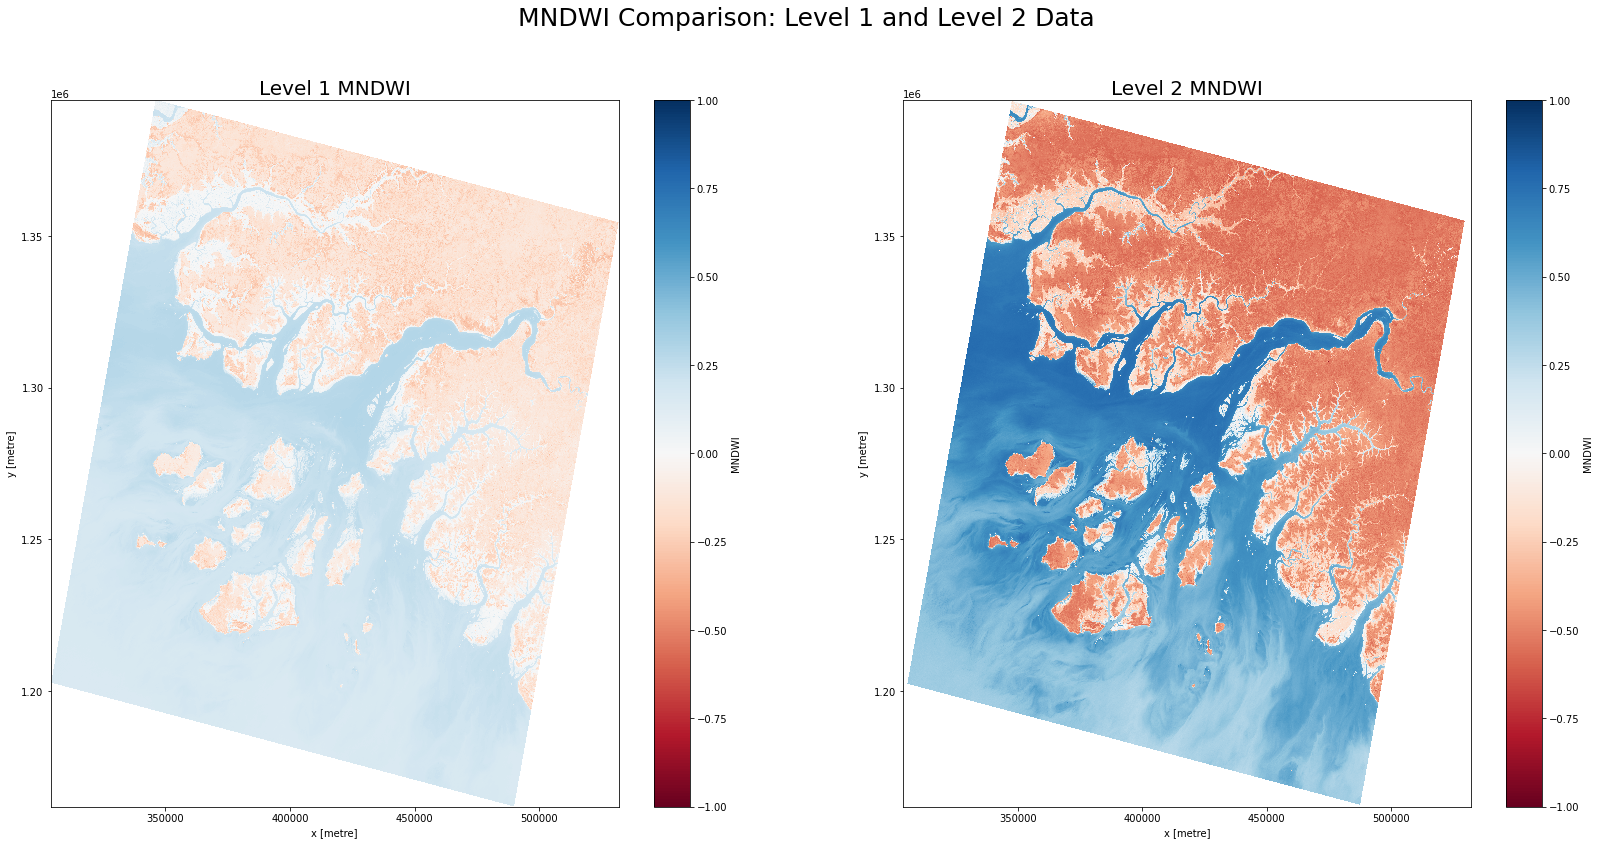

In [9]:
fig1, ax = plt.subplots(1, 2, figsize=(28,13))
fig1.suptitle("MNDWI Comparison: Level 1 and Level 2 Data", size = 25)

l1_data.MNDWI.plot(ax=ax[0], cmap='RdBu', vmin=-1, vmax=1)
ax[0].set_title('Level 1 MNDWI', size = 20)

l2_data.MNDWI.plot(ax=ax[1], cmap='RdBu', vmin=-1, vmax=1)
ax[1].set_title('Level 2 MNDWI', size = 20);

### Waterline close-ups

The improvements provided by Level 2 data can be best exemplified by looking closer at a region where water meets land. We will look at the estuaries of the river Rio Baboque at two different scales.

In [10]:
# Rio Baboque x and y coordinates, in metres
zoomed_xmin = 388000
zoomed_xmax = 403000
zoomed_ymin = 1323000
zoomed_ymax = 1338000

#Note in the Dataset structure, y values are listed in decreasing order, so the ymax is listed first when performing a slice() command in the y dimension

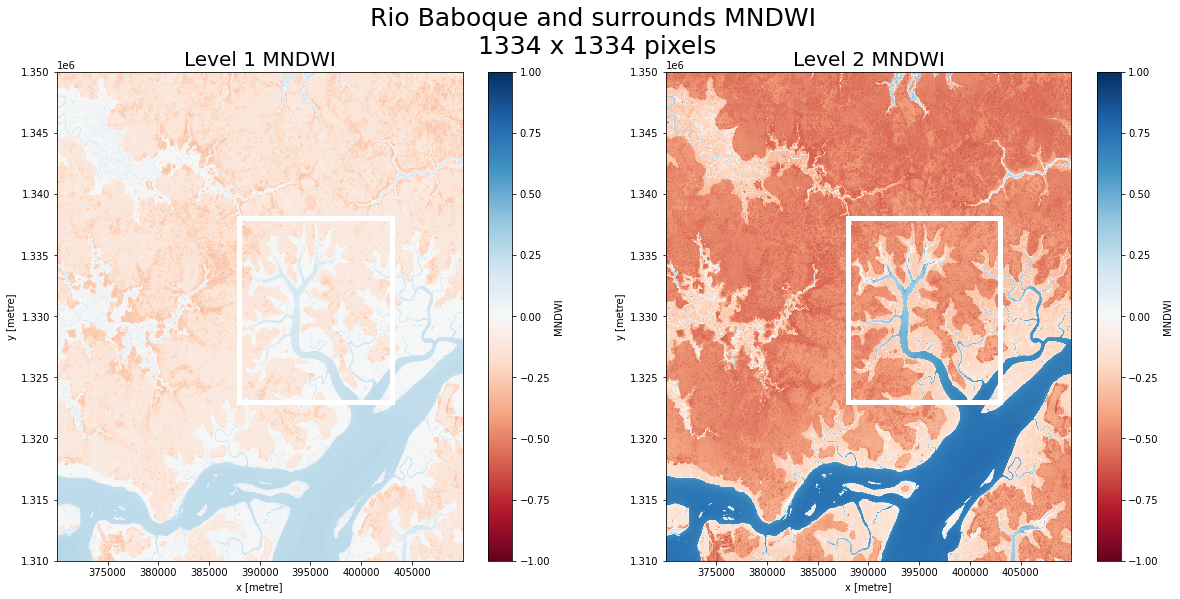

In [11]:
fig2, ax = plt.subplots(1, 2, figsize=(20, 9))
fig2.suptitle("Rio Baboque and surrounds MNDWI \n1334 x 1334 pixels", size=25)

l1_data.MNDWI.sel(x=slice(370000, 410000), y=slice(1350000, 1310000)).plot(
    ax=ax[0], cmap="RdBu", vmin=-1, vmax=1
)
selection = patches.Rectangle(
    (zoomed_xmin, zoomed_ymin),
    15000,
    15000,
    linewidth=5,
    edgecolor="w",
    facecolor="none",
)
ax[0].add_patch(selection)
ax[0].set_title("Level 1 MNDWI", size=20)

l2_data.MNDWI.sel(x=slice(370000, 410000), y=slice(1350000, 1310000)).plot(
    ax=ax[1], cmap="RdBu", vmin=-1, vmax=1
)
selection = patches.Rectangle(
    (zoomed_xmin, zoomed_ymin),
    15000,
    15000,
    linewidth=5,
    edgecolor="w",
    facecolor="none",
)
ax[1].add_patch(selection)
ax[1].set_title("Level 2 MNDWI", size=20);

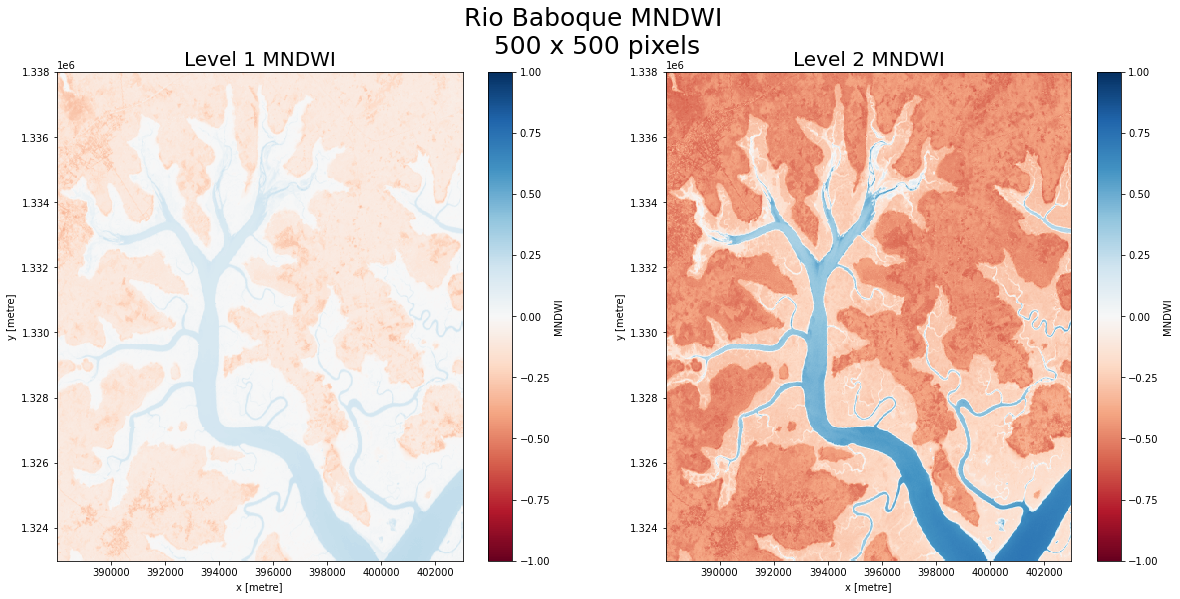

In [12]:
fig3, ax = plt.subplots(1, 2, figsize=(20, 9))
fig3.suptitle("Rio Baboque MNDWI \n500 x 500 pixels", size = 25)

l1_data.MNDWI.sel(x = slice(zoomed_xmin, zoomed_xmax), y = slice(zoomed_ymax, zoomed_ymin)).plot(ax=ax[0], cmap='RdBu', vmin=-1, vmax=1)
ax[0].set_title('Level 1 MNDWI', size = 20)

l2_data.MNDWI.sel(x = slice(zoomed_xmin, zoomed_xmax), y = slice(zoomed_ymax, zoomed_ymin)).plot(ax=ax[1], cmap='RdBu', vmin=-1, vmax=1)
ax[1].set_title('Level 2 MNDWI', size = 20);

## Analysis

### MNDWI distribution profiles

The MNDWI values can be plotted by frequency for the Rio Baboque area. This can be used to show how MNDWI ranges over this geographical region.

/env/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  if sys.path[0] == '':


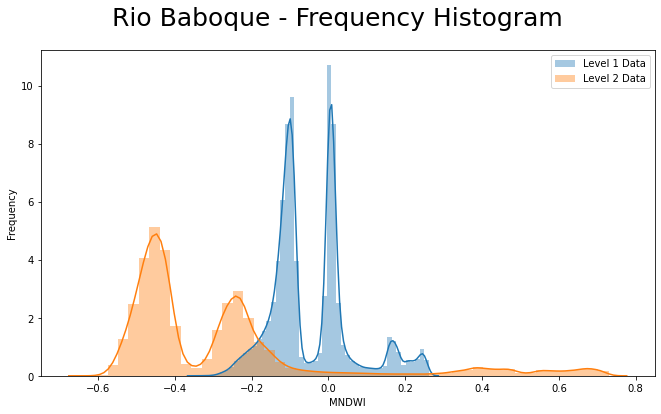

In [13]:
histl1 = l1_data.MNDWI.sel(x = slice(zoomed_xmin, zoomed_xmax), y = slice(zoomed_ymax, zoomed_ymin)).values.ravel()
histl2 = l2_data.MNDWI.sel(x = slice(zoomed_xmin, zoomed_xmax), y = slice(zoomed_ymax, zoomed_ymin)).values.ravel()

fig4, ax = plt.subplots(1, figsize=(11, 6))
fig4.suptitle("Rio Baboque - Frequency Histogram", size = 25)

h1 = sns.distplot(histl1)
h2 = sns.distplot(histl2)

ax.set_xlabel('MNDWI')
ax.set_ylabel('Frequency')
ax.legend([h1, h2], labels = ['Level 1 Data', 'Level 2 Data'], loc = 'upper right')

The conventional threshold for MNDWI is 0; that is:
* MNDWI $> 0$ : water
* MNDWI $\leq 0$ : soil, vegetation, urban areas

As per the histogram, the Level 2 data shows a much clearer distinction between water and non-water areas. Both datasets show the same core features; two significant peaks on the negative end of the index, and two flatter peaks on the positive end.

In the case of the Level 1 data, all four peaks are clustered around 0, with one peak almost centred on 0. Most data points fall between -0.3 to 3. This means it is difficult to distinguish predictions of water and land as the index values are very similar.

In contrast, the Level 2 data has its two major negative-MNDWI peaks centred around -0.25 and -0.45. This clearly denotes those areas as not-water; there is no peak around 0. The positive-MNDWI peaks are less distinct than in the Level 1 data, and this spread over the range shows nuance in regions of water. For example, at the end of estuaries as the channels become narrower there is a gradual decrease in MNDWI. This is not nearly as visible in the Level 1 data.

#### We can demonstrate this below by thresholding both datasets at MDNWI > 0

In [14]:
water1 = l1_data.MNDWI.sel(x=slice(zoomed_xmin, zoomed_xmax), y=slice(zoomed_ymax, zoomed_ymin)) > 0
water2 = l2_data.MNDWI.sel(x=slice(zoomed_xmin, zoomed_xmax), y=slice(zoomed_ymax, zoomed_ymin)) > 0

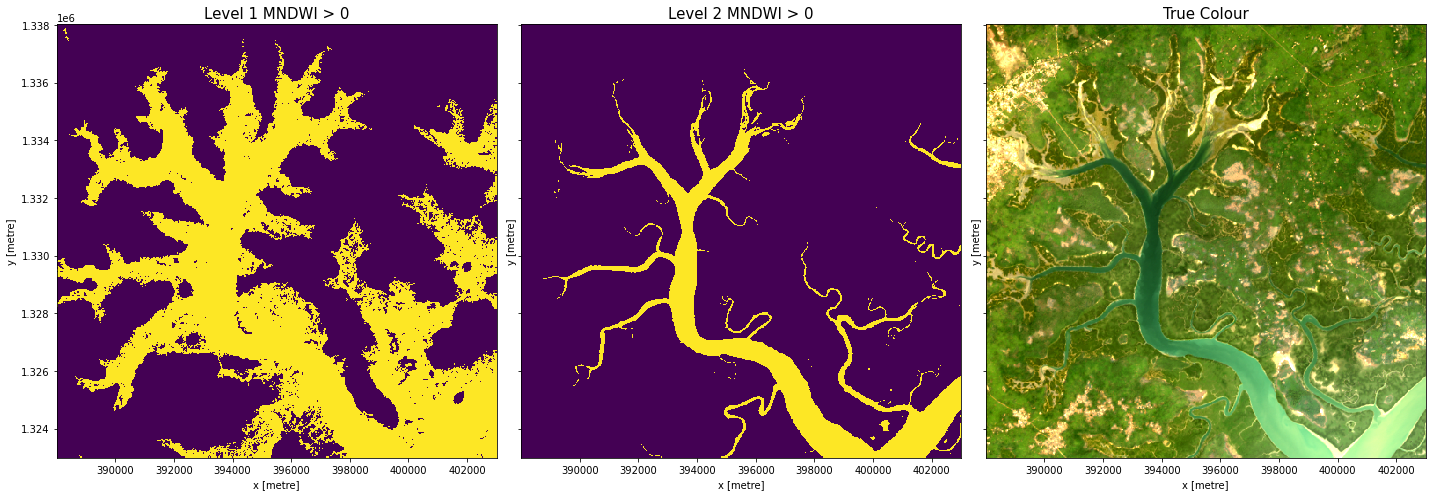

In [15]:
fig, ax = plt.subplots(1, 3, sharey=True, sharex=True, figsize=(20, 7))

water1.plot(ax=ax[0], add_colorbar=False)
ax[0].set_title('Level 1 MNDWI > 0', size = 15)

water2.plot(ax=ax[1], add_colorbar=False)
ax[1].set_title('Level 2 MNDWI > 0', size = 15)

rgb(l2_data.sel(x=slice(zoomed_xmin, zoomed_xmax),
                y=slice(zoomed_ymax, zoomed_ymin)), ax=ax[2])
ax[2].set_title('True Colour', size = 15)

plt.tight_layout();

## Conclusions

### Level 2 data is more suitable for calculating indices such as MNDWI

MNDWI is conventionally thresholded around 0; this is a suitable assumption for data that has been processed for surface reflectance, such as the Level 2 dataset. However, the Level 1 data, which does not contain atmospheric corrections, may require the threshold to be adjusted to optimise MNDWI. This can be an involved process, and the threshold could require recalculation for every scene of Level 1 data.

### Level 2 data is more user-friendly

Throughout this notebook, there have been extra steps taken to manipulate the Level 1 data so it could be visualised.

* Downloading it from the AWS S3 bucket
* Importing bands separately
* Combining bands into a DataSet
* Removing NaNs

These steps preclude actual data analysis and can act as a barrier for new datacube users.

***

**Acknowledgements:** Thank you to Caitlin, Chad, Dave, Alex and Kirill.

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Last modified:** July 2020

**Compatible `datacube` version:** 

In [16]:
print(datacube.__version__)

1.8.2.dev7+gdcab0e02
